# Analysis of "Azerbaijani Laundromat" transaction data

## set up environment

Load the library dependencies

In [1]:
from collections import defaultdict
from datetime import datetime, timedelta
import itertools
import pathlib
import statistics
import typing

from icecream import ic
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import pyvis
import scipy
import seaborn as sns
import watermark

Show a watermark of the OS, hardware, language environment, and dependent library versions.

In [2]:
%load_ext watermark
%watermark
%watermark --iversions

Last updated: 2025-02-23T12:23:03.240044-08:00

Python implementation: CPython
Python version       : 3.13.2
IPython version      : 8.32.0

Compiler    : Clang 16.0.0 (clang-1600.0.26.6)
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

seaborn   : 0.13.2
matplotlib: 3.10.0
pyvis     : 0.3.2
scipy     : 1.15.2
pandas    : 2.2.3
watermark : 2.5.0
networkx  : 3.4.2



Configure `pandas`

In [3]:
pd.set_option("display.max_rows", None)

## load the money transfer data

Load the OCCRP data for the "Azerbaijani Laundromat" leaked bank transactions <https://github.com/cj2001/senzing_occrp_mapping_demo/blob/main/occrp_17k.csv>

In [4]:
occrp_file: pathlib.Path = pathlib.Path("occrp_17k.csv")
df_orig: pd.DataFrame = pd.read_csv(occrp_file)

In [5]:
df_orig.head()

,payer_name,payer_jurisdiction,payer_account,source_file,amount_orig,id,beneficiary_type,beneficiary_core,amount_orig_currency,beneficiary_name,...,beneficiary_name_norm,payer_core,beneficiary_account,purpose,date,amount_usd,amount_eur,payer_type,payer_name_norm,payer_bank_country
0,AZARBAYCAN METANOL KOMPANI MMC,AZ,33817018409333311204,pdf/LCM ALLIANCE Account statement 30.06.12-31...,535470.00,6049,Company,True,USD,LCM ALLIANCE LLP,...,LCM ALLIANCE LLP,False,EE27 3300 3335 0561 0002,1206295100052180 OCT4121800021 ADVANCE PAYM FO...,2012-06-30,535470,"$431,762.31",Company,AZARBAYCAN METANOL KOMPANI MMC,33
1,LCM ALLIANCE LLP,GB,EE27 3300 3335 0561 0002,pdf/LCM ALLIANCE Account statement 30.06.12-31...,-535000.00,6050,Company,False,USD,MOBILA LLP,...,MOBILA LLP,True,333504500003,1207035026699176 INVOICE.No 6215 DD 25.05.2012,2012-07-03,535000,"$423,688.44",Company,LCM ALLIANCE LLP,EE
2,SKN ELECTRICAL SERVICES LIMITEDACCO,GB,20100374548222,pdf/METASTAR Account statement 30.06.12-31.12....,90535.19,10623,Company,True,USD,METASTAR INVEST LLP,...,METASTAR INVEST LLP,False,EE77 3300 3334 8704 0004,"1207065103089249 /FEE/USD4,81",2012-07-06,90536,"$71,698.53",Company,SKN ELECTRICAL SERVICES LIMITED,20
3,METASTAR INVEST LLP,GB,EE77 3300 3334 8704 0004,pdf/METASTAR Account statement 30.06.12-31.12....,-90520.00,15589,Company,False,USD,INMAXO CAPITAL CORP,...,INMAXO CAPITAL CORP.,True,333455870002,1207095022358525 DOGOVOR ZAYMA,2012-07-09,90520,"$71,686.50",Company,METASTAR INVEST LLP,EE
4,METASTAR INVEST LLP,GB,EE77 3300 3334 8704 0004,pdf/METASTAR Account statement 30.06.12-31.12....,-60.00,10624,Company,False,USD,INMAXO CAPITAL CORP,...,INMAXO CAPITAL CORP.,True,333455870002,1207135024578077 DOGOVOR ZAYMA,2012-07-13,60,$47.52,Company,METASTAR INVEST LLP,EE


In [6]:
df_orig.columns

Index(['payer_name', 'payer_jurisdiction', 'payer_account', 'source_file',
       'amount_orig', 'id', 'beneficiary_type', 'beneficiary_core',
       'amount_orig_currency', 'beneficiary_name', 'beneficiary_jurisdiction',
       'investigation', 'beneficiary_bank_country', 'beneficiary_name_norm',
       'payer_core', 'beneficiary_account', 'purpose', 'date', 'amount_usd',
       'amount_eur', 'payer_type', 'payer_name_norm', 'payer_bank_country'],
      dtype='object')

reduce the dataframe to just the slice needed for this analysis

In [7]:
cols_keep: typing.List[ str ] = [
    "date",
    "amount_orig",
    "payer_name",
    "beneficiary_name",
    "purpose",
    ]

diff: typing.Set[ str ] = set(df_orig.columns) - set(cols_keep)
    
df: pd.DataFrame = df_orig.drop(
    diff,
    axis = 1,
    inplace = False,
).sort_values(by = "date").reindex(columns = cols_keep)

df = df[df["amount_orig"] >= 0]
df.date = pd.to_datetime(df.date)

df.head()

,date,amount_orig,payer_name,beneficiary_name,purpose
0,2012-06-30,535470.00,AZARBAYCAN METANOL KOMPANI MMC,LCM ALLIANCE LLP,1206295100052180 OCT4121800021 ADVANCE PAYM FO...
2,2012-07-06,90535.19,SKN ELECTRICAL SERVICES LIMITEDACCO,METASTAR INVEST LLP,"1207065103089249 /FEE/USD4,81"
5,2012-07-13,189352.15,INMAXO CAPITAL CORP.,METASTAR INVEST LLP,CONTRACT N 001 DD 24.12.2009
6,2012-07-13,225850.00,INMAXO CAPITAL CORP.,METASTAR INVEST LLP,1207135026233261 CONTRACT N 001 DD 24.12.2009
21,2012-07-16,150000.00,MOBILA LLP,METASTAR INVEST LLP,1207165026198353 INVOICE.No 69 DD 13.07.2012


In [8]:
azeri_file: pathlib.Path = pathlib.Path("azeri.csv")
df.to_csv(azeri_file, sep = "\t", encoding = "utf-8")

## descriptive statistics

In [9]:
df.describe(include = "all").loc[[ "count", "mean", "min", "max", "std", "freq", "unique", ]]

,date,amount_orig,payer_name,beneficiary_name,purpose
count,4069,4.069000e+03,4069,4069,4069
mean,2013-06-24 13:09:11.191939072,7.512028e+05,NaN,NaN,NaN
min,2012-06-30 00:00:00,6.600000e-01,NaN,NaN,NaN
max,2014-12-31 00:00:00,2.055997e+07,NaN,NaN,NaN
std,NaN,1.206048e+06,NaN,NaN,NaN
freq,NaN,NaN,530,1708,37
unique,NaN,NaN,437,4,3781


In [10]:
float(df["amount_orig"].sum()) / 10**9

3.05664418321

insights:

  * a total of \$3.06B in money transfers flowed through 4K transactions
  * mean transfer amount is \$751K
  * max transfer amount is $1.21M
  * the funds drain into 4 companies

## graph construction

construct a graph in `NetworkX` for analysis, while also tallying the transaction flows, amounts, and inter-arrival times

In [11]:
graph: nx.DiGraph = nx.DiGraph()
node_names: list = []

edge_xact: dict = defaultdict(list)

for index, row in df.iterrows():
    src_label: str = row["payer_name"]
    dst_label: str = row["beneficiary_name"]

    if src_label not in node_names:
        node_names.append(src_label)
        src_id: int = node_names.index(src_label)

        graph.add_node(
            src_id,
            name = src_label,
        )            
    else:
        src_id = node_names.index(src_label)


    if dst_label not in node_names:
        node_names.append(dst_label)
        dst_id: int = node_names.index(dst_label)

        graph.add_node(
            dst_id,
            name = dst_label,
        )
    else:
        dst_id = node_names.index(dst_label)

    graph.add_edge(
        src_id,
        dst_id,
    )

    edge_xact[ (src_id, dst_id) ].append({
        "amount": row["amount_orig"],
        "date": datetime.fromisoformat(str(row["date"])),
    })    

In [12]:
for node_id, degree in sorted(nx.degree(graph), key = lambda x: x[1], reverse = True):
    graph.nodes[node_id]["degree"] = degree

## inter-arrival modeling

describe the distributions of transaction inter-arrival times (days in-between) and amounts

In [13]:
summary_data: list = []

for edge, dat in edge_xact.items():
    if len(dat) > 1:
        dates: list = sorted([
            xact["date"]
            for xact in dat
        ], reverse = False)

        inter_arrival: list = [
            (pair[1] - pair[0]).days
            for pair in itertools.pairwise(dates)
        ]

        amounts: list = [
            xact["amount"]
            for xact in dat
        ]

        summary_data.append({
            "src_id": edge[0],
            "dst_id": edge[1],
            "median_amount": statistics.median(amounts),
            "total_amount": sum(amounts),
            "inter_arrival": statistics.mean(inter_arrival),
        })

df_summary: pd.DataFrame = pd.DataFrame.from_dict(
    summary_data,
    orient = "columns"
)

df_summary.head()

,src_id,dst_id,median_amount,total_amount,inter_arrival
0,0,1,109510.00,1511916.50,39.750000
1,2,3,10101.00,110063.19,59.500000
2,4,3,189352.15,415231.08,1.500000
3,5,3,300000.00,4729714.00,1.916667
4,6,3,50000.00,12747647.00,3.629310


In [14]:
df_summary.describe()

,src_id,dst_id,median_amount,total_amount,inter_arrival
count,252.000000,252.000000,2.520000e+02,2.520000e+02,252.000000
mean,173.626984,40.829365,3.798608e+05,1.161657e+07,21.156845
std,126.250130,101.164882,5.301957e+05,8.014517e+07,32.745006
min,0.000000,1.000000,1.100000e+02,2.200000e+02,0.000000
25%,64.750000,1.000000,6.717762e+04,3.476025e+05,3.000000
50%,157.500000,1.000000,1.963890e+05,1.408894e+06,8.708333
75%,268.000000,3.000000,4.762237e+05,4.850007e+06,25.569444
max,433.000000,302.000000,4.000000e+06,1.239991e+09,211.000000


insights:

  * mean total transfer between two nodes is \$1.16M
  * max total transfer is \$12.7M
  * mean of the median transfer amount between two nodes is \$380K
  * mean inter-arrival time is 21.16 days
  * longest inter-arrival time is 211 days

## general ledger

apply basic accounting practices to model the in-flows, out-flows, and resulting balances

In [15]:
for node_id in graph.nodes():
    graph.nodes[node_id]["volume"] = 0
    graph.nodes[node_id]["credits"] = 0
    graph.nodes[node_id]["debits"] = 0

for index, row in df_summary.iterrows():
    src_id: int = row["src_id"]
    dst_id: int = row["dst_id"]
    amount: float = float(row["total_amount"])

    graph.nodes[src_id]["volume"] += amount
    graph.nodes[src_id]["debits"] += amount

    graph.nodes[dst_id]["volume"] += amount
    graph.nodes[dst_id]["credits"] += amount

for node_id in graph.nodes():
    graph.nodes[node_id]["balance"] = round(graph.nodes[node_id]["credits"] - graph.nodes[node_id]["debits"], 2)

In [16]:
nodes_dat: typing.List[ dict ] = [
    dat
    for _, dat in graph.nodes(data = True)
]

df_nodes: pd.DataFrame = pd.DataFrame.from_dict(
    nodes_dat,
    orient = "columns"
)

df_nodes.head()

,name,degree,volume,credits,debits,balance
0,AZARBAYCAN METANOL KOMPANI MMC,1,1.511916e+06,0.000000e+00,1511916.50,-1.511916e+06
1,LCM ALLIANCE LLP,273,7.926534e+08,7.842097e+08,8443707.00,7.757660e+08
2,SKN ELECTRICAL SERVICES LIMITEDACCO,1,1.100632e+05,0.000000e+00,110063.19,-1.100632e+05
3,METASTAR INVEST LLP,134,4.236822e+08,3.498216e+08,73860598.00,2.759610e+08
4,INMAXO CAPITAL CORP.,1,4.152311e+05,0.000000e+00,415231.08,-4.152311e+05


In [17]:
df_nodes.describe()

,degree,volume,credits,debits,balance
count,437.000000,4.370000e+02,4.370000e+02,4.370000e+02,4.370000e+02
mean,2.205950,1.339759e+07,6.698797e+06,6.698797e+06,-2.727901e-10
std,14.766024,1.111983e+08,8.234222e+07,7.045104e+07,1.054614e+08
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,-1.452793e+09
25%,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,-1.313250e+06
50%,1.000000,4.128350e+03,0.000000e+00,4.128350e+03,0.000000e+00
75%,1.000000,1.425239e+06,0.000000e+00,1.425239e+06,0.000000e+00
max,273.000000,1.538163e+09,1.458096e+09,1.452793e+09,1.378030e+09


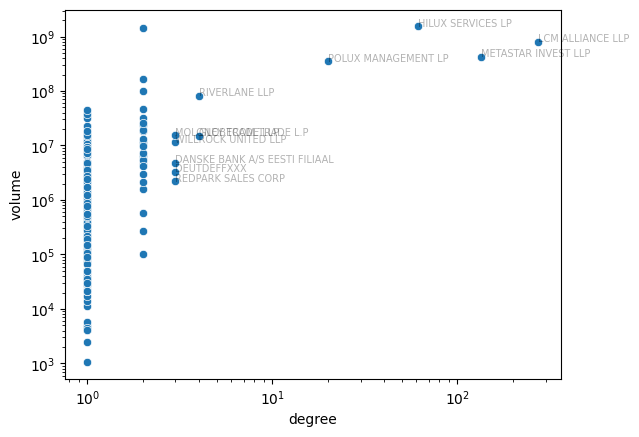

In [18]:
x: list = df_nodes["degree"].to_list()
y: list = df_nodes["volume"].to_list()
labels: list = df_nodes["name"].to_list()

sns.scatterplot(data = df_nodes, x = "degree", y = "volume")

plt.yscale("log")
plt.xscale("log")

for i, label in enumerate(labels):
    if x[i] > 2: # only label the top-ranked 14 companies
        plt.annotate(label, (x[i], y[i]), alpha = 0.3, fontsize = 7)

plt.show()

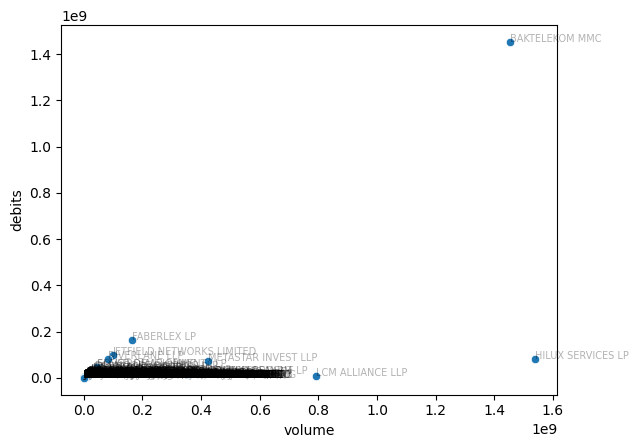

In [19]:
x: list = df_nodes["volume"].to_list()
y: list = df_nodes["debits"].to_list()
labels: list = df_nodes["name"].to_list()

sns.scatterplot(data = df_nodes, x = "volume", y = "debits")

for i, label in enumerate(labels):
    plt.annotate(label, (x[i], y[i]), alpha = 0.3, fontsize = 7)

plt.show()

this chart illustrates the "sources" (negative balance, below center) and "drains" (positive balance, above center)

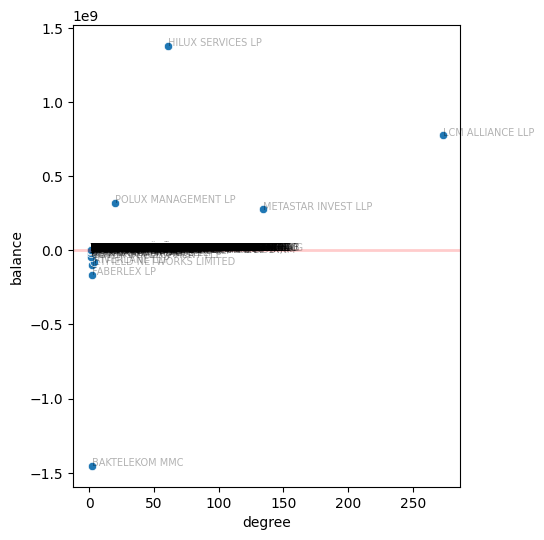

In [20]:
x: list = df_nodes["degree"].to_list()
y: list = df_nodes["balance"].to_list()
labels: list = df_nodes["name"].to_list()

fig, ax = plt.subplots(figsize = (5, 6))
plt.rcParams["font.family"] = "sans-serif"

sns.scatterplot(data = df_nodes, x = "degree", y = "balance")

for i, label in enumerate(labels):
    plt.annotate(label, (x[i], y[i]), alpha = 0.3, fontsize = 7)

plt.axhline(y = 0, color = "red", lw = 2, alpha = 0.2)

plt.show()

insights:

  * funds appear to have sourced through many shell companies, with "BAKTELEKOM MMC" being the largest
  * funds appear to have drained from "LCM", "HILUX", "POLUX", and "METASTAR"

## centrality measure

calculate _betweenness centrality_ measures for each node

In [21]:
ranks: dict = nx.betweenness_centrality(
    graph,
    weight = "volume",
    normalized = True,
    endpoints = True,
)

for node_id, rank in ranks.items():
    graph.nodes[node_id]["rank"] = round(rank, 4)

## simple graph analytics

now we have some descriptive stats to use for modeling a simulation of these kinds of transactions; let's look into other potential parameters for simulation, based on graph analytics

In [22]:
nx.diameter(graph.to_undirected())

4

In [23]:
nx.density(graph)

0.0025297587806772616

In [24]:
nx.girth(graph.to_undirected())

1

In [25]:
node_degree: typing.List[ int ] = dict(nx.degree(graph)).values()
max(node_degree)

273

let's look in detail at the relatively higher degree nodes

In [26]:
for node_id, degree in sorted(nx.degree(graph), key = lambda x: x[1], reverse = True):
    if degree >= 3:
        print(f"{node_id:3} {degree:3}", graph.nodes[node_id])

  1 273 {'name': 'LCM ALLIANCE LLP', 'degree': 273, 'volume': 792653368.8799999, 'credits': 784209661.8799999, 'debits': 8443707.0, 'balance': 775765954.88, 'rank': 0.0039}
  3 134 {'name': 'METASTAR INVEST LLP', 'degree': 134, 'volume': 423682242.37999994, 'credits': 349821644.3799999, 'debits': 73860598.0, 'balance': 275961046.38, 'rank': 0.0028}
302  61 {'name': 'HILUX SERVICES LP', 'degree': 61, 'volume': 1538162666.2199998, 'credits': 1458096291.0399997, 'debits': 80066375.18, 'balance': 1378029915.86, 'rank': 0.0011}
298  20 {'name': 'POLUX MANAGEMENT LP', 'degree': 20, 'volume': 352811832.13, 'credits': 335246788.13, 'debits': 17565044.0, 'balance': 317681744.13, 'rank': 0.0011}
 17   4 {'name': 'GLOBECOM TRADE L.P', 'degree': 4, 'volume': 15165112.0, 'credits': 0, 'debits': 15165112.0, 'balance': -15165112.0, 'rank': 0.0}
 66   4 {'name': 'RIVERLANE LLP', 'degree': 4, 'volume': 82016410.99000001, 'credits': 0, 'debits': 82016410.99000001, 'balance': -82016410.99, 'rank': 0.0}
 

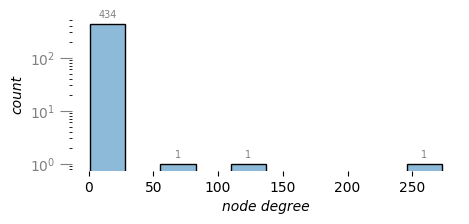

In [27]:
fig, ax = plt.subplots(figsize = (5, 2))
plt.rcParams["font.family"] = "sans-serif"

y = sns.histplot(node_degree)
y.tick_params(axis = "y", size = 9, colors = "gray")
y.bar_label(y.containers[0], padding = 3, color = "gray", fontsize = 7)

plt.xlabel("node degree", size = 10, fontstyle = "italic")
plt.ylabel("count", size = 10, fontstyle = "italic")

sns.despine(bottom = True, left = True)
plt.yscale("log")

plt.legend([], [], frameon = False);

insights:

  * a sparse directed graph with cycles
  * not wide, `diameter = 4`
  * power law distribution on node degree

## components and paths

In [28]:
for clique in nx.connected_components(graph.to_undirected()):
    print(clique)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [29]:
len(list(nx.strongly_connected_components(graph)))

435

In [30]:
strong_edges: list = []

for clique in nx.strongly_connected_components(graph):
    if len(clique) > 1:
        strong_edges.append(sorted(list(clique)))
        print("\n", clique)

        for node_id in clique:
            dat: dict = graph.nodes[node_id]
            print(f"{node_id:3}", dat["name"])


 {1, 3}
  1 LCM ALLIANCE LLP
  3 METASTAR INVEST LLP

 {298, 302}
298 POLUX MANAGEMENT LP
302 HILUX SERVICES LP


In [31]:
path_counts: typing.List[ int ] = [
    len(path[1]) + 1
    for path in nx.all_pairs_all_shortest_paths(graph)
]

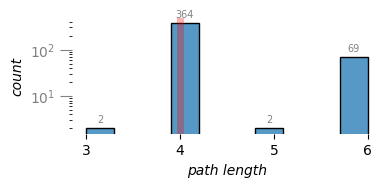

In [32]:
fig, ax = plt.subplots(figsize = (4, 1.5))
plt.rcParams["font.family"] = "sans-serif"

y = sns.histplot(path_counts)
y.tick_params(axis = "y", size = 9, colors = "gray")
y.bar_label(y.containers[0], padding = 3, color = "gray", fontsize = 7)

plt.xlabel("path length", size = 10, fontstyle = "italic")
plt.ylabel("count", size = 10, fontstyle = "italic")

plt.axvline(x = statistics.median(path_counts), color = "red", lw = 5, alpha = 0.3)

plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
y.set(xticks = range(min(path_counts), max(path_counts) + 1))

sns.despine(bottom = True, left = True)
plt.yscale("log")

plt.legend([], [], frameon = False);

insights:

  * fully connected graph, `avg path length = 4`
  * 2 strongly connected components, among pairs of the "drain" shell companies

## flow analysis

In [33]:
nx.flow_hierarchy(graph)

0.9896265560165975

since most of the nodes are on the periphery, what's happening in-between them?

In [34]:
for node_id in nx.center(graph.to_undirected()):
    print(node_id, graph.nodes[node_id])

17 {'name': 'GLOBECOM TRADE L.P', 'degree': 4, 'volume': 15165112.0, 'credits': 0, 'debits': 15165112.0, 'balance': -15165112.0, 'rank': 0.0}
66 {'name': 'RIVERLANE LLP', 'degree': 4, 'volume': 82016410.99000001, 'credits': 0, 'debits': 82016410.99000001, 'balance': -82016410.99, 'rank': 0.0}


label each node based on its "role"

In [35]:
neg_bal: int = 0  # sources
pos_bal: int = 0  # drains
zed_bal: int = 0  # conduits

for node_id in nx.periphery(graph.to_undirected()):
    dat: dict = graph.nodes[node_id]

    if dat["balance"] < 0:
        graph.nodes[node_id]["role"] = "source"
        neg_bal += 1
    elif dat["balance"] > 0:
        graph.nodes[node_id]["role"] = "drain"
        pos_bal += 1
    else:
        graph.nodes[node_id]["role"] = "conduit"
        zed_bal += 1

ic(neg_bal, pos_bal, zed_bal);

ic| neg_bal: 208, pos_bal: 0, zed_bal: 215


In [36]:
len(graph.nodes)

437

In [37]:
len(list(nx.periphery(graph.to_undirected())))

423

In [38]:
non_periph: set = set(graph.nodes) - set(nx.periphery(graph.to_undirected()))

details: dict = {
    node_id: graph.nodes[node_id]
    for node_id in non_periph
}

for node_id, dat in sorted(details.items(), key = lambda pair: pair[1]["rank"], reverse = True):
    print(f"{node_id:3}", dat)

  1 {'name': 'LCM ALLIANCE LLP', 'degree': 273, 'volume': 792653368.8799999, 'credits': 784209661.8799999, 'debits': 8443707.0, 'balance': 775765954.88, 'rank': 0.0039}
  3 {'name': 'METASTAR INVEST LLP', 'degree': 134, 'volume': 423682242.37999994, 'credits': 349821644.3799999, 'debits': 73860598.0, 'balance': 275961046.38, 'rank': 0.0028}
298 {'name': 'POLUX MANAGEMENT LP', 'degree': 20, 'volume': 352811832.13, 'credits': 335246788.13, 'debits': 17565044.0, 'balance': 317681744.13, 'rank': 0.0011}
302 {'name': 'HILUX SERVICES LP', 'degree': 61, 'volume': 1538162666.2199998, 'credits': 1458096291.0399997, 'debits': 80066375.18, 'balance': 1378029915.86, 'rank': 0.0011}
 66 {'name': 'RIVERLANE LLP', 'degree': 4, 'volume': 82016410.99000001, 'credits': 0, 'debits': 82016410.99000001, 'balance': -82016410.99, 'rank': 0.0}
  7 {'name': 'DANSKE BANK A/S EESTI FILIAAL', 'degree': 3, 'volume': 4799052.71, 'credits': 0, 'debits': 4799052.71, 'balance': -4799052.71, 'rank': 0.0}
170 {'name': '

let's keep track of these intermediary nodes in particular, which don't rank as high in centrality -- what is flowing through them?

In [39]:
intermed: typing.Set[ int ] = non_periph - set([ 1, 302, 298, 3, ])

insights:

  * nodes in the periphery are split between "sources" (negative balance) and "conduits" (zero balance, intermediaries to hide eventual end outflows), though none are "drains" (end with a positive balance)

  * 10 intermediary nodes don't rank as high in centrality as the 4 main shell companies mentioned in the investigative journalism articles
     * these 10 are in the computed "center" of the graph
     * what patterns of transactions flow through these?

## directed flows

In [40]:
for node_id in graph.nodes():
    deg: int = graph.in_degree(node_id)

    if deg > 0:
        dat = graph.nodes[node_id]
        graph.nodes[node_id]["role"] = "drain"
        print(f"{deg:3} in degree {node_id:3}", dat["name"])

272 in degree   1 LCM ALLIANCE LLP
132 in degree   3 METASTAR INVEST LLP
 18 in degree 298 POLUX MANAGEMENT LP
 60 in degree 302 HILUX SERVICES LP


In [41]:
for node_id in graph.nodes():
    deg: int = graph.out_degree(node_id)
    graph.nodes[node_id]["out_deg"] = deg

    if deg > 1:
        graph.nodes[node_id]["role"] = "center"

In [42]:
flows_dat: list = [
    {
        "node_id": node_id,
        "name": dat["name"],
        "role": dat["role"],
        "out_deg": dat["out_deg"],
        "balance": dat["balance"],
        "volume": dat["volume"],
        "credits": dat["credits"],
        "debits": dat["debits"],        
    }
    for node_id, dat in graph.nodes(data = True)
    if dat["out_deg"] > 0
]

df_flows: pd.DataFrame = pd.DataFrame.from_dict(
    flows_dat,
    orient = "columns"
)

df_flows.head()

,node_id,name,role,out_deg,balance,volume,credits,debits
0,0,AZARBAYCAN METANOL KOMPANI MMC,source,1,-1.511916e+06,1.511916e+06,0.000000e+00,1511916.50
1,1,LCM ALLIANCE LLP,drain,1,7.757660e+08,7.926534e+08,7.842097e+08,8443707.00
2,2,SKN ELECTRICAL SERVICES LIMITEDACCO,source,1,-1.100632e+05,1.100632e+05,0.000000e+00,110063.19
3,3,METASTAR INVEST LLP,center,2,2.759610e+08,4.236822e+08,3.498216e+08,73860598.00
4,4,INMAXO CAPITAL CORP.,source,1,-4.152311e+05,4.152311e+05,0.000000e+00,415231.08


In [43]:
df_flows.describe(include = "all").loc[[ "count", "mean", "min", "max", "std", "freq", "unique", ]]

,node_id,name,role,out_deg,balance,volume,credits,debits
count,437.000000,437,437,437.000000,4.370000e+02,4.370000e+02,4.370000e+02,4.370000e+02
mean,218.000000,NaN,NaN,1.102975,-2.727901e-10,1.339759e+07,6.698797e+06,6.698797e+06
min,0.000000,NaN,NaN,1.000000,-1.452793e+09,0.000000e+00,0.000000e+00,0.000000e+00
max,436.000000,NaN,NaN,4.000000,1.378030e+09,1.538163e+09,1.458096e+09,1.452793e+09
std,126.295289,NaN,NaN,0.378208,1.054614e+08,1.111983e+08,8.234222e+07,7.045104e+07
freq,NaN,1,215,NaN,NaN,NaN,NaN,NaN
unique,NaN,437,4,NaN,NaN,NaN,NaN,NaN


In [44]:
df_flows.groupby(["role"]).count()["node_id"]

role
center      36
conduit    215
drain        2
source     184
Name: node_id, dtype: int64

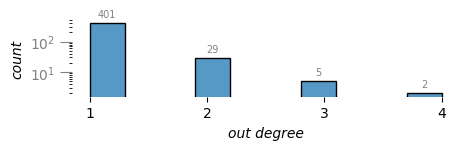

In [45]:
dat = df_flows["out_deg"].to_list()

fig, ax = plt.subplots(figsize = (5, 1))
plt.rcParams["font.family"] = "sans-serif"

y = sns.histplot(dat)
y.tick_params(axis = "y", size = 9, colors = "gray")
y.bar_label(y.containers[0], padding = 3, color = "gray", fontsize = 7)

plt.xlabel("out degree", size = 10, fontstyle = "italic")
plt.ylabel("count", size = 10, fontstyle = "italic")

plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
y.set(xticks = range(min(dat), max(dat) + 1))

sns.despine(bottom = True, left = True)
plt.yscale("log")

plt.legend([], [], frameon = False);

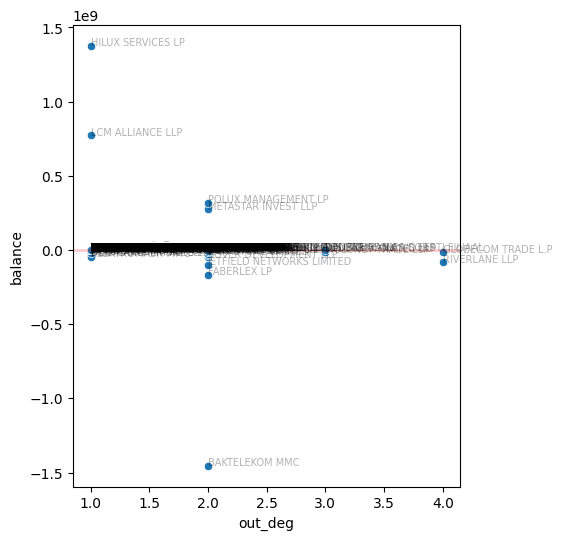

In [46]:
x: list = df_flows["out_deg"].to_list()
y: list = df_flows["balance"].to_list()
labels: list = df_flows["name"].to_list()

fig, ax = plt.subplots(figsize = (5, 6))
plt.rcParams["font.family"] = "sans-serif"

sns.scatterplot(data = df_flows, x = "out_deg", y = "balance")

for i, label in enumerate(labels):
    plt.annotate(label, (x[i], y[i]), alpha = 0.3, fontsize = 7)

plt.axhline(y = 0, color = "red", lw = 2, alpha = 0.2)

plt.show()

here are the shell companies which had more funds transferred out than transferred in

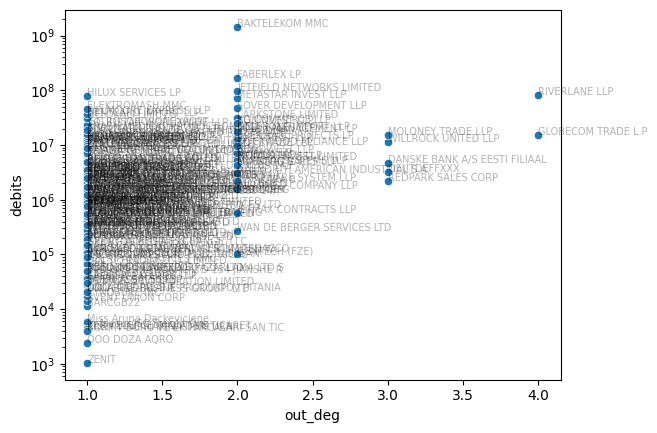

In [47]:
x: list = df_flows["out_deg"].to_list()
y: list = df_flows["debits"].to_list()
labels: list = df_flows["name"].to_list()

sns.scatterplot(data = df_flows, x = "out_deg", y = "debits")

for i, label in enumerate(labels):
    plt.annotate(label, (x[i], y[i]), alpha = 0.3, fontsize = 7)

plt.yscale("log")
plt.show()

insights:

  * role "source" = 208
  * role "conduit" = 215
  * role "center" = 10
  * role "drain" = 4

## triadic census

In [48]:
for triad, occurrences in sorted(nx.triadic_census(graph).items(), key = lambda x: x[1], reverse = True):
    if occurrences > 0:
        print(f"triad {triad:>5}: {occurrences:7d} occurrences")

triad   003: 13652536 occurrences
triad   012:  113313 occurrences
triad  021U:   46815 occurrences
triad   102:     425 occurrences
triad  111D:     411 occurrences
triad  120D:      33 occurrences
triad  021D:      19 occurrences
triad  021C:      15 occurrences
triad  030T:       2 occurrences
triad  111U:       1 occurrences


<img
 src="https://figures.semanticscholar.org/6ebe86cdf25f3b58dd98dd9c1c00c3f5c2491734/2-Figure1-1.png"
 style="height:500px"
/>

insights:

  * do the many `021U` triads indicate "burst in beneficiaries" AML tradecraft pattern?

## network visualization

In [49]:
role_colors: dict = {
    "source": "#BDC561",
    "conduit": "#E8EAE0",
    "center": "#D9CAD7",
    "drain": "#C25FB8",
}

role_shapes: dict = {
    "source": "square",
    "conduit": "triangle",
    "center": "diamond",
    "drain": "circle",
}

In [50]:
def render_graph (
    graph: nx.DiGraph,
    ) -> pyvis.network.Network:
    """
    Generate a `PyVis` network visualization from the DiGraph
    """
    net: pyvis.network.Network = pyvis.network.Network(
        notebook = True,
        cdn_resources = "in_line",
        directed = False,
        height = "900px", 
        width = "100%",
    )
    
    # adjust node attributes
    net.from_nx(graph)

    for node in net.nodes:
        node["value"] = node["volume"]
        node["label"] = node["name"]

        node["color"] = role_colors[node["role"]]
        node["shape"] = role_shapes[node["role"]]

        if node["name"] == "BAKTELEKOM MMC":
            node["color"] = "#3381EA"

        title: str = node["name"] + "\nnode_id: " + str(node["id"])

        for key in [ "role", "rank", ]:
            title += f"\n{key}: " + str(node[key])

        for key in [ "volume", "balance", "credits", "debits", ]:
            title += f"\n{key}: {node[key]:.3e}"
        
        node["title"] = title
    
    # adjust edge attributes
    for edge in net.edges:
        arc: list = sorted([ edge["from"], edge["to"] ])

        if arc in strong_edges:
            edge["width"] = 10

    return net

construct a graph `PyVis` for visualization

In [51]:
net: pyvis.network.Network = render_graph(graph)

net.force_atlas_2based()
net.toggle_physics(True)

net.prep_notebook()
net.show_buttons(filter_ = [ "physics" ])

options: str =     """
  "physics": {
    "forceAtlas2Based": {
      "centralGravity": 0.04,
      "springLength": 5,
      "springConstant": 0.32,
      "avoidOverlap": 0.02
    },
    "minVelocity": 0.75,
    "solver": "forceAtlas2Based"
  }
    """

#net.set_options(options)
# setting options via Py interface doesn't work?

net.show("occrp.html")

occrp.html


## summary

take-aways:

 * this is a relatively sparse directed graph with `diameter = 4`, with cycles
 * the money transfers in the dataset account for $3.06B
 * power law distribution on node degree, with `max node degree = 273`
 * fully connected, although with no _strongly connected components_
 * 423 nodes of 437 total are in the periphery, while 10 are in the computed "center", and 4 are well-known from investigative journalism
 * periphery nodes split between negative balance (multiple sources for funds) and zero balance (intermediaries to hide the eventual end outflows); none end with a positive balance

questions:

 * do the many `021U` triads indicate "burst in beneficiaries" AML tradecraft patterns?

OCCRP analysis and the subsequent investigative journalism articles mention the 4 top shell companies involved in the "Azerbaijani Laundromat", in order of centrality: "LCM", "HILUX", "POLUX", "METASTAR". 

`NetworkX` identifies 423 nodes out of a 437 total as "peripheral", so then what kind of patterns occur involving the other intermediate shell companies?

The remaining 10 shell companies of interest about tradecraft patterns are located approximately at the computed "center" of the graph:

  * "DANSKE BANK A/S EESTI FILIAAL"
  * "RIVERLANE LLP"
  * "GLOBECOM TRADE L.P"
  * "MOLONEY TRADE LLP"
  * "DEUTDEFFXXX"
  * "WILLROCK UNITED LLP"
  * "HARDWARE SYSTEM LLP"
  * "BONDWEST LLP"
  * "DELFRONT IMPORT LLP"
  * "REDPARK SALES CORP"

Note that the leaked transaction data came from an Estonian branch of Danske Bank, which is one of these intermediary nodes identified: "DANSKE BANK A/S EESTI FILIAAL" https://thebanks.eu/banks/13002

These intermediaries appear to be where some initial inflows of funds primarily were sourced?

Orders of magnitude larger amounts of funds appear to have sourced into "BAKTELEKOM MMC" plus another ~200 companies in the periphery (to a lesser extent) then drained mostly out of "LCM", "HILUX", "POLUX", and "METASTAR"